# Tanzania Water Wells Project

## Imports

### 1a. Imports

### 1b. Copy Data

## Models

### 2. Data Organization and Functions

### 3. Pipelines (Numerical/Categorical) and Column Transformer

### 4a. Baseline (Dummy) Model

### 4b. First Simple Model

### 5. GridSearch - Choosing Hyperparameters

### 6. Final Logistic Regression Model

## Imports

In [43]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, log_loss


from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

In [2]:
# import data

tanzania = pd.read_csv('data/final_df.csv')


# copy data

tanzania_with_dates = tanzania.copy()

In [3]:
#drop construction year and data column

tanzania.drop(['construction_year'], axis = 1, inplace = True)
tanzania.drop(['date_recorded'], axis = 1, inplace = True)

In [4]:
## adjust numerical columns for modeling 

# change to int64
tanzania['amount_tsh'] = tanzania['amount_tsh'].fillna(0).astype(int)


In [5]:
# change empties (0's) to nan for model

tanzania['amount_tsh'][tanzania['amount_tsh'] == 0] = np.nan

<ipython-input-5-bb4e9670bf4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tanzania['amount_tsh'][tanzania['amount_tsh'] == 0] = np.nan


In [6]:
#check 

tanzania.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             17757 non-null  float64
 1   basin                  59400 non-null  object 
 2   subvillage             59400 non-null  object 
 3   region                 59400 non-null  object 
 4   population             59400 non-null  int64  
 5   public_meeting         59400 non-null  object 
 6   permit                 59400 non-null  object 
 7   extraction_type_class  59400 non-null  object 
 8   management             59400 non-null  object 
 9   payment_type           59400 non-null  object 
 10  quality_group          59400 non-null  object 
 11  quantity               59400 non-null  object 
 12  source                 59400 non-null  object 
 13  waterpoint_type        59400 non-null  object 
 14  status_group           59400 non-null  object 
 15  Ag

## Model

### 2. Data Organization and Functions

In [7]:
# data organize for model

X = tanzania.drop(["status_group"], axis = 1)
y = tanzania['status_group'] # target

In [8]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [9]:
#evaluate model fxn

def eval(model, X_train, y_train, X_test, y_test):
    print(f"""
    Train Accuracy Score: {round(accuracy_score(y_train, model.predict(X_train)), 4)} 
    Test Accuracy Score: {round(accuracy_score(y_test, model.predict(X_test)), 4)}
    
    Train Precision Score: {round(precision_score(y_train, model.predict(X_train), average='weighted'), 4)}
    Test Precision Score: {round(precision_score(y_test, model.predict(X_test), average='weighted'), 4)} 
    
    Train Recall Score: {round(recall_score(y_train, model.predict(X_train), average='weighted'), 4)}
    Test Recall Score: {round(recall_score(y_test, model.predict(X_test), average='weighted'), 4)} 
    
    Train F1 Score: {round(f1_score(y_train, model.predict(X_train), average='weighted'), 4)}
    Test F1 Score: {round(f1_score(y_test, model.predict(X_test), average='weighted'), 4)} 
    
    Confusion Matrix:""") 

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20, 12))

    # Plot the confusion matrix
    plot_confusion_matrix(model, X_test, y_test, normalize='true', 
                          display_labels=['Functional', 'Functional Needs Repair', 'Non Functional'], ax = ax,
                         cmap = 'Blues')
    
    # Add labels and title
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    # Show the plot
    plt.show()

### 3. Pipelines (Numerical/Categorical) and Column Transformer

In [10]:
# pipelines for numerical and categorical data

num_pipe = Pipeline(steps = [
    
    ('num_impute', SimpleImputer(strategy = 'most_frequent')), # justify this 
    ('ss', StandardScaler())

])


cat_pipe = Pipeline(steps = [
    
    ('cat_impute', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(sparse = True, handle_unknown = 'ignore')) #ohe for categorical

])

In [11]:
# cols

num_cols = ['amount_tsh', 'population', 'Age']
cat_cols = ['basin', 'subvillage',
                     'region', 'public_meeting', 'permit',
                    'extraction_type_class', 'management', 'payment_type', 
                    'quality_group', 'quantity', 
                    'source', 'waterpoint_type']

In [12]:
#column transformers

CT = ColumnTransformer(transformers = [('num_pipeline', num_pipe, num_cols),
                                       ('cat_pipeline', cat_pipe, cat_cols)])

### 4a. Baseline(Dummy) Model

In [13]:
#dummy model

dummy_pipe = Pipeline(steps=([
    ("ct", CT), 
    ("dc", DummyClassifier())

]))


In [14]:
# fit 

dummy_pipe.fit(X_train, y_train)

/Users/kaceyclougher/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'population',
                                                   'Age']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unk

In [15]:
# score

dummy_pipe.score(X_train, y_train)

0.44835016835016833

In [16]:
# ^ TRASH

### 4b. First Simple Model (Logistic Regression)

In [17]:
# first model to check out

log_reg_fsm = Pipeline([
    
    ('ct', CT), 
    ('log_reg', LogisticRegression())
    
    
])

In [18]:
#fit

log_reg_fsm.fit(X_train, y_train)

/Users/kaceyclougher/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'population',
                                                   'Age']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unk

In [19]:
# score

log_reg_fsm.score(X_train, y_train, )

0.8015263748597082


    Train Accuracy Score: 0.8015 
    Test Accuracy Score: 0.7479
    
    Train Precision Score: 0.8008
    Test Precision Score: 0.737 
    
    Train Recall Score: 0.8015
    Test Recall Score: 0.7479 
    
    Train F1 Score: 0.7857
    Test F1 Score: 0.7288 
    
    Confusion Matrix:


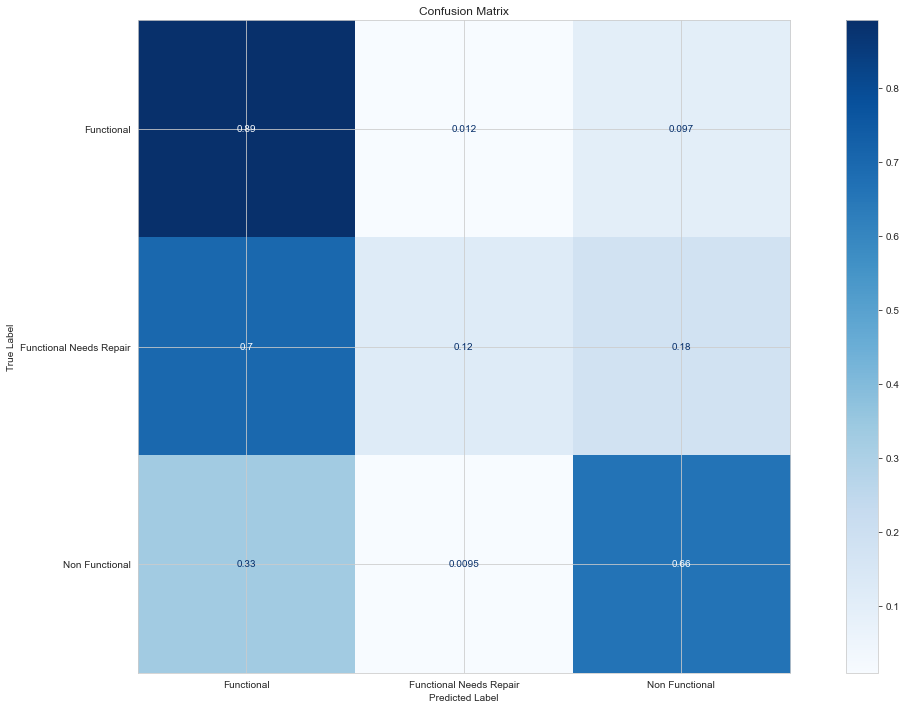

In [20]:
eval(log_reg_fsm, X_train, y_train, X_test, y_test)

### 5. GridSearch

In [21]:
# get params

log_reg_fsm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'log_reg', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__num_pipeline', 'ct__cat_pipeline', 'ct__num_pipeline__memory', 'ct__num_pipeline__steps', 'ct__num_pipeline__verbose', 'ct__num_pipeline__num_impute', 'ct__num_pipeline__ss', 'ct__num_pipeline__num_impute__add_indicator', 'ct__num_pipeline__num_impute__copy', 'ct__num_pipeline__num_impute__fill_value', 'ct__num_pipeline__num_impute__missing_values', 'ct__num_pipeline__num_impute__strategy', 'ct__num_pipeline__num_impute__verbose', 'ct__num_pipeline__ss__copy', 'ct__num_pipeline__ss__with_mean', 'ct__num_pipeline__ss__with_std', 'ct__cat_pipeline__memory', 'ct__cat_pipeline__steps', 'ct__cat_pipeline__verbose', 'ct__cat_pipeline__cat_impute', 'ct__cat_pipeline__ohe', 'ct__cat_pipeline__cat_impute__add_indicator', 'ct__cat_pipeline__cat_impute__copy', 'ct__cat_pipeline__cat_impute__fill_value', 'ct__cat_pipelin

In [22]:
#parameter grid

param_grid = {
#    'log_reg__C': [0, 1, 10],
#    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#    'log_reg__penalty': ['l1', 'l2'],
#    'log_reg__class_weight': [None, 'balanced'],
#    'log_reg__max_iter': [100, 200, 300],
#    'ct__num_pipeline__num_impute__strategy': ['mean', 'median', 'most_frequent', 'constant']
}

In [23]:
#creating gridsearch

gridsearch = GridSearchCV(log_reg_fsm, param_grid, cv = 5, verbose = 1, n_jobs = -1)

In [24]:
# fitting gridsearch

## Takes approx 6 hours
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
/Users/kaceyclougher/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'population',
                                                                          'Age']),
                                                                        ('cat_pipeline',
                                                       

In [29]:
#best params and model

best_params = gridsearch.best_params_
best_model = gridsearch.best_estimator_

In [30]:
#print results

accuracy = best_model.score(X_test, y_test)

print("Best Parameters:", best_params)
print("Accuracy of the Best Model:", accuracy)

Best Parameters: {}
Accuracy of the Best Model: 0.7479461279461279


## 6. Final Logistic Regression Model

In [46]:
model = Pipeline([
    ('ct', CT),
#    ('smote', SMOTE(random_state = 42)),
    ('log_reg', LogisticRegression(solver = 'newton-cg', C = 1, class_weight = None, max_iter = 300, penalty = 'l2',
                                 multi_class = 'multinomial'))
])


In [33]:
#cross validate

cross_validate(model, X_train, y_train, return_train_score = True)

{'fit_time': array([9.07634306, 9.62411904, 8.58611894, 8.11386919, 9.06961608]),
 'score_time': array([0.0429101 , 0.04492497, 0.04667902, 0.04566908, 0.0486939 ]),
 'test_score': array([0.75723906, 0.75308642, 0.75319865, 0.75140292, 0.74298541]),
 'train_score': array([0.8270202 , 0.82766554, 0.82901235, 0.82979798, 0.82974186])}

In [34]:
#fit model

model.fit(X_train,y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'population',
                                                   'Age']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unk

In [35]:
# score

model.score(X_train, y_train)

0.8268237934904602


    Train Accuracy Score: 0.8268 
    Test Accuracy Score: 0.7512
    
    Train Precision Score: 0.8293
    Test Precision Score: 0.7435 
    
    Train Recall Score: 0.8268
    Test Recall Score: 0.7512 
    
    Train F1 Score: 0.8141
    Test F1 Score: 0.7337 
    
    Confusion Matrix:


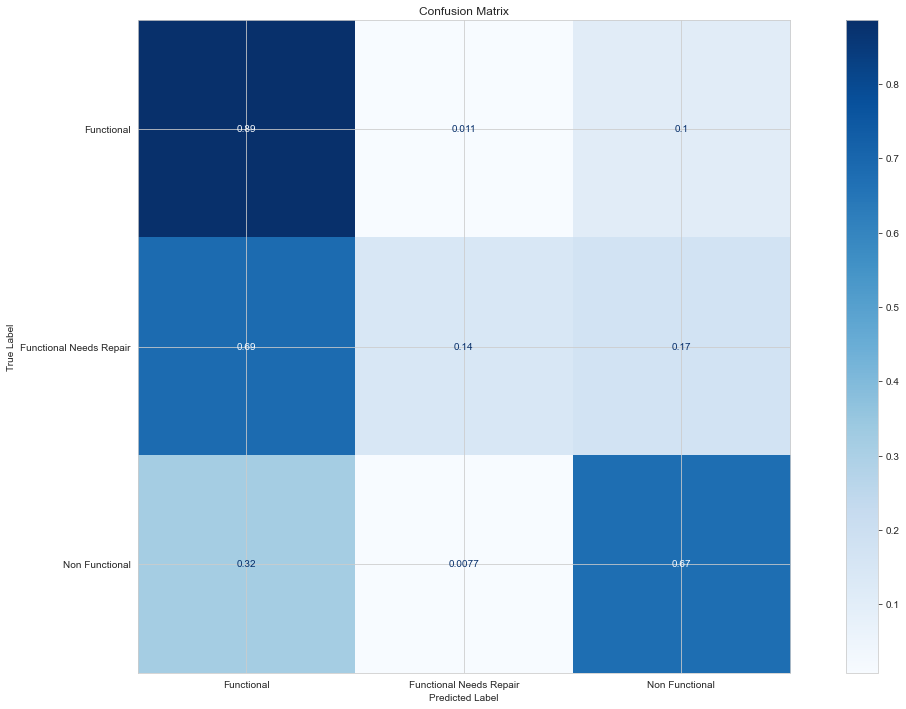

In [36]:
# eval -- run model

eval(model, X_train, y_train, X_test, y_test)

In [37]:
#Accuracy Score: 75.51% of the instances in the test set were correctly classified!

#Precision Score: 74.74% - among instances predicted as positive in the test set, 74.27% were actually positive!

#Recall Score: 75516% of the actual positive instances in the test set were correctly identified by the model! (great)

#F1 Score: 73.7% - F1 score in the test set balances precision and recall

In [40]:
#log loss

ll = log_loss(y_train, model.predict_proba(X_train))
print("Log Loss:", ll)

Log Loss: 0.45413421767932494


In [41]:
#low log loss indicates probabilities are closer to the truwe class labels